In [1]:
import pandas as pd
import numpy as np
import hrvanalysis as hrv
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import os
import re
import dateutil.parser as dp
import scipy.stats as ss
import matplotlib.patches as mp
import matplotlib.dates as md
%config InlineBackend.figure_format = 'svg'

In [2]:
sb.set(font_scale=1)

# Batch processing

In [3]:
files_peaks = glob.glob('*peaks*', recursive=True)

In [4]:
def datetime(s):
    date = re.search('^\d{4,4}-\d+-\d+', s)
    time = re.search(' \d{2,2}-\d+-\d+', s)
    datetime = date[0] + ' ' + (time[0].strip() if time else '')
    return pd.to_datetime(datetime, format='%Y-%m-%d %H-%M-%S')

In [8]:
df = pd.DataFrame()

for file in files_peaks:
    df_peaks = pd.read_csv(file, header=None, sep=' ', names=['x', 'y'], index_col=0)
    df_peaks = df_peaks[df_peaks > 500].dropna()
    
    rr = np.diff(df_peaks.index)
    nn = np.array(hrv.get_nn_intervals(rr, verbose=False))
    nn = nn[~np.isnan(nn)]

    params = hrv.get_frequency_domain_features(nn)
    params.update(hrv.get_time_domain_features(nn))
    params.update(hrv.get_csi_cvi_features(nn))

    hrv_score = 20 * np.log(params['rmssd'])
    mode = ss.mode(nn)[0][0]
    hist = np.histogram(nn, bins=np.arange(0, 2500, 50))
    mid1 = np.argwhere(hist[1] > mode)[0][0] - 1
    mid2 = mid1 + 1
    amo = (hist[0][mid1:mid2].item() / len(rr)) * 100
    isb = amo / (2 * mode) / (rr.max() - rr.min()) * 1000 * 1000

    df_results = pd.DataFrame(params, index=[df.shape[0]])
    df_results['hrv_score'] = hrv_score
    df_results['baevsky_index'] = isb
    df_results['file'] = os.path.basename(file)
    df_results['datetime'] = datetime(os.path.basename(file))
    df = df.append(df_results, sort=False)

df.set_index('datetime', inplace=True)

0 outlier(s) have been deleted.
2 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
1 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
11 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
7 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
5 ectopic beat(s) have been deleted with kamath rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) hav

In [9]:
df.sort_index(inplace=True)

# HRV score and Stress index (Baevsky, 2009)

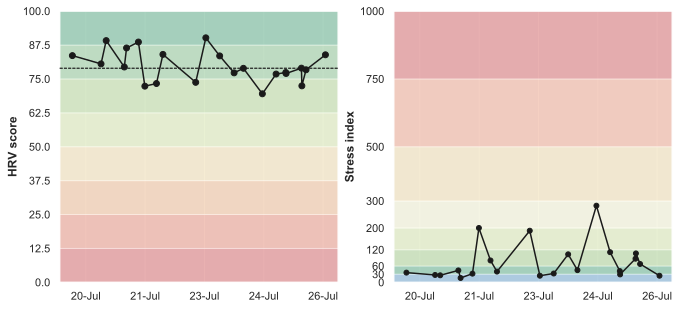

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11,5))

ax1.plot(df.index, df['hrv_score'], marker='o', color='k', clip_on=False, zorder=10)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MultipleLocator(12.5))
ax1.xaxis.set_tick_params(rotation=0)
[tick.set_horizontalalignment("center") for tick in ax1.xaxis.get_majorticklabels()]
ax1.grid(True, alpha=0.33)
ax1.set_ylim(0, 100)
ax1.set_ylabel('HRV score', weight="bold")
ydata = [np.arange(0, 100, 12.5).tolist(),
         ['#d73027','#f46d43','#fdae61','#fee08b','#d9ef8b','#a6d96a','#66bd63','#1a9850']]
for y1, fc in zip(*ydata):
    ax1.add_patch(mp.Rectangle((ax1.get_xlim()[0], y1), ax1.get_xlim()[1], 12.5, fc=fc, alpha=0.33))
ax1.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax1.add_line(ax1.axhline(df['hrv_score'].median(), 0, 1, ls='--', color='k', lw=0.8, zorder=100))

ax2.plot(df.index, df['baevsky_index'], marker='o', ms=5, clip_on=False, color='k', zorder=10)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
ax2.yaxis.set_ticks([0, 30, 60, 120, 200, 300, 500, 750, 1000])
ax2.xaxis.set_tick_params(rotation=0)
[tick.set_horizontalalignment("center") for tick in ax2.xaxis.get_majorticklabels()]
ax2.set_ylim(0, 1000)
ax2.set_ylabel('Stress index', weight="bold")
ax2.grid(True, alpha=0.33)
ydata = [[0, 30, 60, 120, 200, 300, 500, 750],
         [30, 30, 60, 80, 100, 200, 250, 250],
         ['#3288bd','#1a9850','#91cf60','#d9ef8b','#ffffbf','#fee08b','#fc8d59','#d73027']]
for y1, y2, fc in zip(*ydata):
    ax2.add_patch(mp.Rectangle((ax2.get_xlim()[0], y1), ax2.get_xlim()[1], y2, fc=fc, alpha=0.33))
ax2.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))

# Dataset

In [ ]:
df.sort_index().tail()